# Learning Scikit-learn: Machine Learning in Python

## Notebook for Chapter 2: Supervised Learning: Explaining Titanic Hypothesis with Decision Trees

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Preprocessing

First, we must load the dataset. We assume it is located in the data/titanic.csv file

In [2]:
import csv
import numpy as np
with open('data/titanic.csv', 'rb') as csvfile:
    titanic_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    # Header contains feature names
    row = titanic_reader.next()
    feature_names = np.array(row)
    
    # Load dataset, and target classes
    titanic_X, titanic_y = [], []
    for row in titanic_reader:  
        titanic_X.append(row)
        titanic_y.append(row[2]) # The target value is "survived"
    
    titanic_X = np.array(titanic_X)
    titanic_y = np.array(titanic_y)


In [3]:
print feature_names, titanic_X[0], titanic_y[0]


['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex'] ['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 1


Keep only class (1st,2nd,3rd), age (float), and sex (masc, fem)

In [4]:
# we keep the class, the age and the sex
titanic_X = titanic_X[:, [1, 4, 10]]
feature_names = feature_names[[1, 4, 10]]


In [5]:
print feature_names
print titanic_X[12], titanic_y[12]

['pclass' 'age' 'sex']
['1st' 'NA' 'female'] 1


Solve missing values ('NA') for the 'age' feature. Solution: use the mean value.

In [6]:
# We have missing values for age
# Assign the mean value
ages = titanic_X[:, 1]
mean_age = np.mean(titanic_X[ages != 'NA', 1].astype(np.float))
titanic_X[titanic_X[:, 1] == 'NA', 1] = mean_age


In [7]:
print feature_names
print titanic_X[12], titanic_y[12]


['pclass' 'age' 'sex']
['1st' '31.1941810427' 'female'] 1


Class and sex are categorical classes. Sex can be converted to a binary value (0=female,1=male):

In [8]:
# Encode sex 
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 2])
print "Categorical classes:", label_encoder.classes_
integer_classes = label_encoder.transform(label_encoder.classes_)
print "Integer classes:", integer_classes
€€
titanic_X[:, 2] = t


Categorical classes: ['female' 'male']
Integer classes: [0 1]


In [9]:
print feature_names
print titanic_X[12], titanic_y[12]


['pclass' 'age' 'sex']
['1st' '31.1941810427' '0'] 1


Now, we have to convert the class. Since we have three different classes, we cannot convert to binary values (and using 0/1/2 values would imply an order, something we do not want). We use OneHotEncoder to get three different attributes

In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 0])
print "Categorical classes:", label_encoder.classes_
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3, 1)
print "Integer classes:", integer_classes
enc = OneHotEncoder()
one_hot_encoder = enc.fit(integer_classes)
# First, convert clases to 0-(N-1) integers using label_encoder
num_of_rows = titanic_X.shape[0]
t = label_encoder.transform(titanic_X[:, 0]).reshape(num_of_rows, 1)
# Second, create a sparse matrix with three columns, each one indicating if the instance belongs to the class
new_features = one_hot_encoder.transform(t)
# Add the new features to titanix_X
titanic_X = np.concatenate([titanic_X, new_features.toarray()], axis = 1)
#Eliminate converted columns
titanic_X = np.delete(titanic_X, [0], 1)
# Update feature names
feature_names = ['age', 'sex', 'first_class', 'second_class', 'third_class']
# Convert to numerical values
titanic_X = titanic_X.astype(float)
titanic_y = titanic_y.astype(float)


Categorical classes: ['1st' '2nd' '3rd']
Integer classes: [[0]
 [1]
 [2]]


In [11]:
print feature_names
print titanic_X[0], titanic_y[0]

['age', 'sex', 'first_class', 'second_class', 'third_class']
[ 29.   0.   1.   0.   0.] 1.0


Separate training and test sets

In [12]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)


### Decision Trees

Fit a decision tree with the data.

In [13]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf = clf.fit(X_train,y_train)

Show the built tree, using pydot

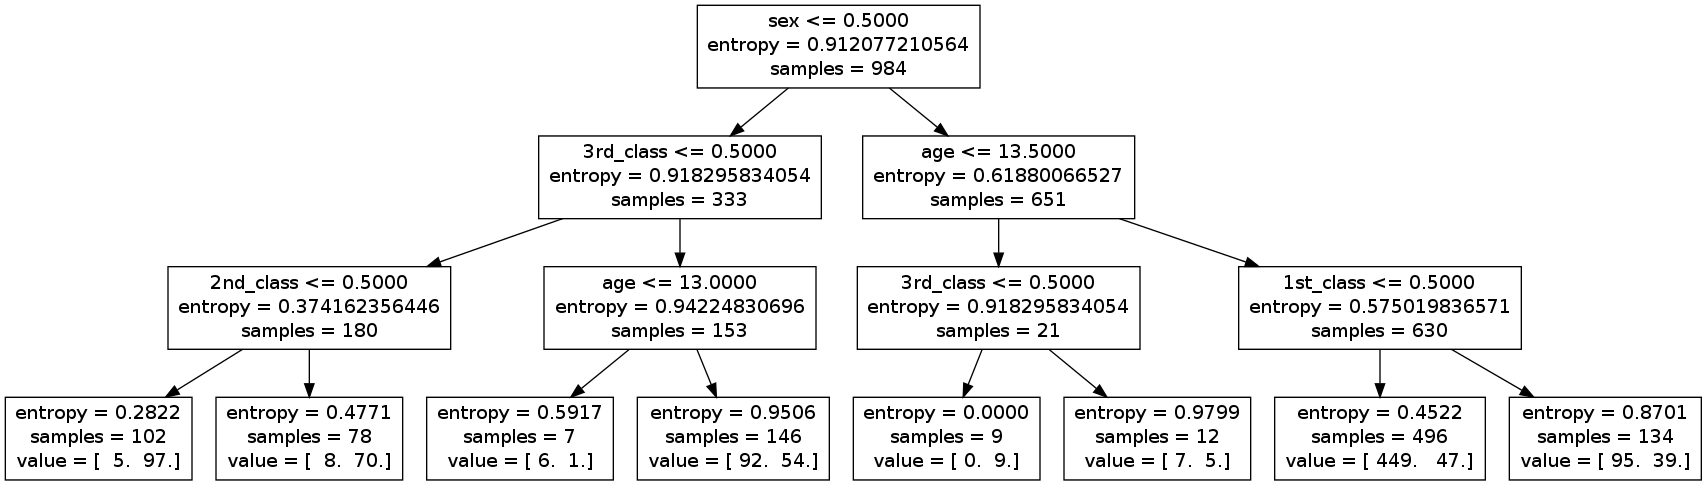

In [14]:
import pydot,StringIO
dot_data = StringIO.StringIO() 
tree.export_graphviz(clf, out_file=dot_data, feature_names=['age','sex','1st_class','2nd_class','3rd_class']) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('titanic.png') 
from IPython.core.display import Image 
Image(filename='titanic.png')

Measure Accuracy, precision, recall, f1 in the training set

In [15]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n"

    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y,y_pred),"\n"
        
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y,y_pred),"\n"
        
measure_performance(X_train,y_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.838 



Perform leave-one-out cross validation to better measure performance, reducing variance

In [16]:
from sklearn.cross_validation import cross_val_score, LeaveOneOut
from scipy.stats import sem

def loo_cv(X_train,y_train,clf):
    # Perform Leave-One-Out cross validation
    # We are preforming 1313 classifications!
    loo = LeaveOneOut(X_train[:].shape[0])
    scores=np.zeros(X_train[:].shape[0])
    for train_index,test_index in loo:
        X_train_cv, X_test_cv= X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv= y_train[train_index], y_train[test_index]
        clf = clf.fit(X_train_cv,y_train_cv)
        y_pred=clf.predict(X_test_cv)
        scores[test_index]=metrics.accuracy_score(y_test_cv.astype(int), y_pred.astype(int))
    print ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))



In [17]:
loo_cv(X_train, y_train,clf)


Mean score: 0.837 (+/-0.012)


Try to improve performance using Random Forests

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10,random_state=33)
clf = clf.fit(X_train,y_train)
loo_cv(X_train,y_train,clf)

Mean score: 0.817 (+/-0.012)


To evaluate performance on future data, evaluate on the training set and test on the evaluation set

In [19]:
clf_dt=tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf_dt.fit(X_train,y_train)
measure_performance(X_test,y_test,clf_dt)



Accuracy:0.793 

Classification report
             precision    recall  f1-score   support

        0.0       0.77      0.96      0.85       202
        1.0       0.88      0.54      0.67       127

avg / total       0.81      0.79      0.78       329


Confusion matrix
[[193   9]
 [ 59  68]] 

